# Residual Networks (ResNet)


In [1]:
import d2l
from mxnet import gluon, np, npx
from mxnet.gluon import nn
npx.set_np()

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256, resize=96)

Residual block

In [2]:
class Residual(nn.Block):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

A situation where the input and output are of the same shape.

In [3]:
blk = Residual(3)
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk(X).shape

(4, 3, 6, 6)

Halve the output height and width while increasing the number of output channels

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

(4, 6, 3, 3)

The ResNet block

In [5]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

The model

In [6]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1),
        resnet_block(64, 2, first_block=True),
        resnet_block(128, 2),
        resnet_block(256, 2),
        resnet_block(512, 2),
        nn.GlobalAvgPool2D(), 
        nn.Dense(10))

Training

loss 0.011, train acc 0.997, test acc 0.894
12520.9 exampes/sec on gpu(0)


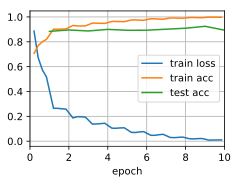

In [7]:
d2l.train_ch5(net, train_iter, test_iter, num_epochs=10, lr=0.05)